# Group: Great
## Author: Bowen Zhao
## zID: z5446616
### Introduction and Motivation:
In this project, our group choose to do Computer Vision project, specifically in image segmentation. We decide to use different models to train and test the dataset we choose and try to figure out the different such as the strength and weakness with different models.


### Data Source
In our project, we use the dataset named Clothing Co-Parsing.

This dataset has 2,098 high-resolution street fashion photos with totally 59 tags. And we use 80% of the dataset to train and the rest of dataset for testing.

we download the data from:
https://github.com/bearpaw/clothing-co-parsing.git

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

!git clone https://github.com/bearpaw/clothing-co-parsing.git

In [2]:
path = 'clothing-co-parsing/'
training_restore_path = 'training.restore'
use_cuda = True

In [3]:
from PIL import Image
import scipy.io
import glob
import os
import numpy as np
import torch
import pandas as pd
from skimage import color
import matplotlib.pyplot as plt
from torch.autograd.grad_mode import F
from tqdm import tqdm

## Model
U2-Net is the model I used in our project, this model is a two-level nested U-structure architecture that is designed for salient object detection (SOD). The architecture allows the network to go deeper, attain high resolution, without significantly increasing the memory and computation cost.

1.   First, the network is a two-layer nested U-shaped structure that does not use a pre-trained backbone model for image classification and can be trained from scratch
2.   Second, this architecture allows the network to go deeper and achieve high resolution without significantly increasing memory and computational costs. At the bottom layer, a new RSU is designed, which can extract multi-scale features within the stage without reducing the resolution of the feature map; at the top layer, there is a structure similar to U-Net, and each stage is filled by an RSU block.

Besides, this model consists of three parts:
1. Six-level encoder
2. Five-stage decoder
3. Saliency map fusion model connected to decoder and final stage encoder


And in the encoder section, it separately use RSU7 RSU6 RSU5 and RSU4’s RSU structure and use the extension RSU4 as RSU-4F in en-5 and en-6 in order to prevent the loss of useful context. In the meantime, the decoder5 also use the RSU-4F.

In [4]:
# Github: https://github.com/levindabhi/cloth-segmentation

import torch
import torch.nn as nn
import torch.nn.functional as F


class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()

        self.conv_s1 = nn.Conv2d(
            in_ch, out_ch, 3, padding=1 * dirate, dilation=1 * dirate
        )
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self, x):
        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout


## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src, tar):
    src = F.upsample(src, size=tar.shape[2:], mode="bilinear")

    return src


### RSU-7 ###
class RSU7(nn.Module):  # UNet07DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):
        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d = self.rebnconv6d(torch.cat((hx7, hx6), 1))
        hx6dup = _upsample_like(hx6d, hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6dup, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6, hx7
        del hx6d, hx5d, hx3d, hx2d
        del hx2dup, hx3dup, hx4dup, hx5dup, hx6dup
        """

        return hx1d + hxin


### RSU-6 ###
class RSU6(nn.Module):  # UNet06DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):
        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6
        del hx5d, hx4d, hx3d, hx2d
        del hx2dup, hx3dup, hx4dup, hx5dup
        """

        return hx1d + hxin


### RSU-5 ###
class RSU5(nn.Module):  # UNet05DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):
        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4, hx5
        del hx4d, hx3d, hx2d
        del hx2dup, hx3dup, hx4dup
        """

        return hx1d + hxin


### RSU-4 ###
class RSU4(nn.Module):  # UNet04DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):
        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        """
        del hx1, hx2, hx3, hx4
        del hx3d, hx2d
        del hx2dup, hx3dup
        """

        return hx1d + hxin


### RSU-4F ###
class RSU4F(nn.Module):  # UNet04FRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):
        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx2d = self.rebnconv2d(torch.cat((hx3d, hx2), 1))
        hx1d = self.rebnconv1d(torch.cat((hx2d, hx1), 1))

        """
        del hx1, hx2, hx3, hx4
        del hx3d, hx2d
        """

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super(U2NET, self).__init__()

        self.stage1 = RSU7(in_ch, 32, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 32, 128)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(128, 64, 256)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(256, 128, 512)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(512, 256, 512)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage6 = RSU4F(512, 256, 512)

        # decoder
        self.stage5d = RSU4F(1024, 256, 512)
        self.stage4d = RSU4(1024, 128, 256)
        self.stage3d = RSU5(512, 64, 128)
        self.stage2d = RSU6(256, 32, 64)
        self.stage1d = RSU7(128, 16, 64)

        self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side3 = nn.Conv2d(128, out_ch, 3, padding=1)
        self.side4 = nn.Conv2d(256, out_ch, 3, padding=1)
        self.side5 = nn.Conv2d(512, out_ch, 3, padding=1)
        self.side6 = nn.Conv2d(512, out_ch, 3, padding=1)

        self.outconv = nn.Conv2d(6 * out_ch, out_ch, 1)

    def forward(self, x):
        hx = x

        # stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        # stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        # stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        # stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        # stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        # stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        # -------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        # side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        """
        del hx1, hx2, hx3, hx4, hx5, hx6
        del hx5d, hx4d, hx3d, hx2d, hx1d
        del hx6up, hx5dup, hx4dup, hx3dup, hx2dup
        """

        return d0, d1, d2, d3, d4, d5, d6


In [5]:
device = torch.device('mps')
#if use_cuda and torch.cuda.is_available() else torch.device('cpu')

learning_rate = 1e-5
Net = U2NET(in_ch=3, out_ch=59)
Net = Net.to('mps')

optimizer = torch.optim.Adam(params=Net.parameters(),
                             lr=learning_rate)

In [6]:
# From Tobias's Nptebook
def downsample(nparr, n):
    return nparr[::n, ::n]


def pad_data(data, y):
    ext = np.array([data[len(data) - 1] for _ in range(data.shape[0], y)])
    if len(ext) > 0:
        data = np.concatenate([data, ext])
    return data


def load_labels():
    mat = scipy.io.loadmat(path + '/label_list.mat')
    label_list = [arr[0] for arr in mat['label_list'][0]]
    return label_list


def load_data():
    annotations = [(os.path.basename(path), scipy.io.loadmat(path)['groundtruth']) for path in
                   sorted(glob.glob(path + '/annotations/pixel-level/*.mat'))]
    data_and_anno = [(fname, anno, Image.open(path + "/photos/" + os.path.splitext(fname)[0] + '.jpg')) for
                     (fname, anno) in annotations]
    return data_and_anno


Data Saving Method

In [9]:
data_and_anno = load_data()

In [10]:
import torchvision
import torchvision.transforms as tf

width = int(520 / 4) + 8  # try to make it same as downsample(ann, ...) below
height = int(873 / 4) + 1  # try to make it same as downsample(ann, ...) below

transform_img = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)),
                            tf.ToTensor()])  # , tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transform_ann = lambda ann: torch.tensor(downsample(ann, 4))

images = torch.stack([transform_img(pad_data(np.array(img), 873)) for (_, _, img) in data_and_anno])
annotations = torch.stack([transform_ann(pad_data(ann, 873)) for (_, ann, _) in data_and_anno])

test_size = int(len(data_and_anno) * 0.2)
test_data = images[:test_size]
train_data = images[test_size:]
test_target = annotations[:test_size]
train_target = annotations[test_size:]


In [11]:
def get_labels(pred):
    # pred.shape = (batchsize, classes=59, height, width)
    # for each class, get the highest probability indices
    _, ind = pred.topk(1, 1, True, True)
    ind = ind.squeeze(dim=1)  # (batchsize, height, width)
    return ind


def remove_labels(actual, pred, labels):
    for label in labels:
        ind = actual == label
        actual = np.delete(actual, ind)
        pred = np.delete(pred, ind)
        ind = pred == label
        actual = np.delete(actual, ind)
        pred = np.delete(pred, ind)
    return (actual, pred)


def num_matches(pred, target):
    labels = get_labels(pred)
    matches = labels.eq(target)  # [[[True, False, True, ...],..],...]
    num_matches = matches.view(-1).float().sum().item()
    return num_matches


def try_restore():
    global Net, optimizer
    epoch = 0
    if os.path.exists(training_restore_path):
        state = torch.load(training_restore_path)
        epoch = state['epoch']
        Net = state['net']
        optimizer = state['opt']
    return epoch

## Training method
In my part, I trained the model for 50 epoches and the modify the training code in order to suitable for the multiple layers in U2Net.

In [12]:
def train(save=True, epoch=0):
    Net.train()
    dataset = torch.utils.data.TensorDataset(train_data, train_target)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=10)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    for epoch in range(epoch, 50):
        correct = 0
        total = 0
        for (data, target) in tqdm(dataloader):
            optimizer.zero_grad()
            data = data.type(torch.FloatTensor).to(device)
            d0, d1, d2, d3, d4, d5, d6 = Net(data)
            target = target.type(torch.LongTensor).to(device)

            loss0 = criterion(d0, target)
            loss1 = criterion(d1, target)
            loss2 = criterion(d2, target)
            loss3 = criterion(d3, target)
            loss4 = criterion(d4, target)
            loss5 = criterion(d5, target)
            loss6 = criterion(d6, target)
            del d1, d2, d3, d4, d5, d6

            total_loss = loss0 * 1.5 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
            d0_loss = loss0

            total_loss.backward()
            optimizer.step()

            correct += num_matches(d0, target)
            total += target.size()[0] * target.size()[1] * target.size()[2]
        accuracy = 100 * correct / total
        print('ep:%5d loss: %6.4f acc: %5.2f' % (epoch, d0_loss.item(), accuracy))
        if save and epoch % 5 == 0:
            torch.save({'epoch': epoch, 'net': Net, 'opt': optimizer}, training_restore_path)



train()


  0%|          | 0/81 [00:00<?, ?it/s]/Users/mac/PycharmProjects/pythonProject6/venv/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 81/81 [02:14<00:00,  1.66s/it]


ep:    0 loss: 1.1980 acc: 72.39


100%|██████████| 81/81 [02:10<00:00,  1.61s/it]


ep:    1 loss: 0.9259 acc: 79.42


100%|██████████| 81/81 [02:08<00:00,  1.59s/it]


ep:    2 loss: 0.7901 acc: 79.89


100%|██████████| 81/81 [02:11<00:00,  1.62s/it]


ep:    3 loss: 0.7052 acc: 80.66


100%|██████████| 81/81 [02:36<00:00,  1.93s/it]


ep:    4 loss: 0.6458 acc: 81.54


100%|██████████| 81/81 [02:15<00:00,  1.68s/it]


ep:    5 loss: 0.6101 acc: 82.55


100%|██████████| 81/81 [02:19<00:00,  1.72s/it]


ep:    6 loss: 0.5610 acc: 83.86


100%|██████████| 81/81 [02:04<00:00,  1.53s/it]


ep:    7 loss: 0.5307 acc: 84.67


100%|██████████| 81/81 [02:12<00:00,  1.64s/it]


ep:    8 loss: 0.5120 acc: 85.45


100%|██████████| 81/81 [02:14<00:00,  1.66s/it]


ep:    9 loss: 0.4732 acc: 86.21


100%|██████████| 81/81 [02:16<00:00,  1.68s/it]


ep:   10 loss: 0.4461 acc: 87.11


100%|██████████| 81/81 [02:11<00:00,  1.62s/it]


ep:   11 loss: 0.4209 acc: 87.93


100%|██████████| 81/81 [02:10<00:00,  1.61s/it]


ep:   12 loss: 0.3785 acc: 88.67


100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


ep:   13 loss: 0.3618 acc: 89.28


100%|██████████| 81/81 [02:17<00:00,  1.70s/it]


ep:   14 loss: 0.3299 acc: 89.89


100%|██████████| 81/81 [02:40<00:00,  1.98s/it]


ep:   15 loss: 0.2941 acc: 90.49


100%|██████████| 81/81 [02:38<00:00,  1.96s/it]


ep:   16 loss: 0.2686 acc: 91.11


100%|██████████| 81/81 [02:30<00:00,  1.85s/it]


ep:   17 loss: 0.2415 acc: 91.71


100%|██████████| 81/81 [02:41<00:00,  1.99s/it]


ep:   18 loss: 0.2249 acc: 92.11


100%|██████████| 81/81 [02:29<00:00,  1.84s/it]


ep:   19 loss: 0.2218 acc: 92.42


100%|██████████| 81/81 [02:10<00:00,  1.61s/it]


ep:   20 loss: 0.2001 acc: 92.60


100%|██████████| 81/81 [02:04<00:00,  1.53s/it]


ep:   21 loss: 0.1919 acc: 92.76


100%|██████████| 81/81 [02:04<00:00,  1.54s/it]


ep:   22 loss: 0.1848 acc: 92.90


100%|██████████| 81/81 [02:03<00:00,  1.53s/it]


ep:   23 loss: 0.1851 acc: 93.09


100%|██████████| 81/81 [20:41<00:00, 15.33s/it]   


ep:   24 loss: 0.1774 acc: 93.47


100%|██████████| 81/81 [02:26<00:00,  1.81s/it]


ep:   25 loss: 0.1667 acc: 93.79


100%|██████████| 81/81 [02:28<00:00,  1.83s/it]


ep:   26 loss: 0.1530 acc: 94.11


100%|██████████| 81/81 [02:20<00:00,  1.73s/it]


ep:   27 loss: 0.1496 acc: 94.39


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


ep:   28 loss: 0.1458 acc: 94.58


100%|██████████| 81/81 [02:09<00:00,  1.60s/it]


ep:   29 loss: 0.1334 acc: 94.72


100%|██████████| 81/81 [02:10<00:00,  1.61s/it]


ep:   30 loss: 0.1279 acc: 94.87


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


ep:   31 loss: 0.1270 acc: 95.00


100%|██████████| 81/81 [02:03<00:00,  1.53s/it]


ep:   32 loss: 0.1205 acc: 95.05


100%|██████████| 81/81 [02:03<00:00,  1.53s/it]


ep:   33 loss: 0.1194 acc: 95.10


100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


ep:   34 loss: 0.1185 acc: 95.19


100%|██████████| 81/81 [02:05<00:00,  1.55s/it]


ep:   35 loss: 0.1210 acc: 95.24


100%|██████████| 81/81 [02:04<00:00,  1.54s/it]


ep:   36 loss: 0.1158 acc: 95.32


100%|██████████| 81/81 [02:04<00:00,  1.54s/it]


ep:   37 loss: 0.1099 acc: 95.28


100%|██████████| 81/81 [02:12<00:00,  1.64s/it]


ep:   38 loss: 0.1087 acc: 95.31


100%|██████████| 81/81 [02:17<00:00,  1.70s/it]


ep:   39 loss: 0.1114 acc: 95.37


100%|██████████| 81/81 [02:10<00:00,  1.61s/it]


ep:   40 loss: 0.1052 acc: 95.47


100%|██████████| 81/81 [02:17<00:00,  1.70s/it]


ep:   41 loss: 0.1129 acc: 95.54


100%|██████████| 81/81 [02:20<00:00,  1.73s/it]


ep:   42 loss: 0.1011 acc: 95.79


100%|██████████| 81/81 [02:11<00:00,  1.62s/it]


ep:   43 loss: 0.0909 acc: 95.93


100%|██████████| 81/81 [02:05<00:00,  1.55s/it]


ep:   44 loss: 0.0902 acc: 96.04


100%|██████████| 81/81 [02:05<00:00,  1.55s/it]


ep:   45 loss: 0.0919 acc: 96.13


100%|██████████| 81/81 [02:05<00:00,  1.55s/it]


ep:   46 loss: 0.0848 acc: 96.16


100%|██████████| 81/81 [02:05<00:00,  1.55s/it]


ep:   47 loss: 0.0846 acc: 96.22


100%|██████████| 81/81 [02:03<00:00,  1.53s/it]


ep:   48 loss: 0.0890 acc: 96.30


100%|██████████| 81/81 [02:04<00:00,  1.54s/it]

ep:   49 loss: 0.0783 acc: 96.33


In [ ]:
def eval():
    Net.eval()
    dataset = torch.utils.data.TensorDataset(test_data, test_target)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    correct = 0
    total = 0
    loss = 0
    preds = []
    labels = []

    for data, target in dataloader:
        labels.append(np.array(target))
        data = data.type(torch.FloatTensor).to(device)
        target = target.type(torch.LongTensor).to(device)
        with torch.no_grad():
            pred = Net(data)

        preds.append(np.array(get_labels(pred[0]).to(torch.device('cpu'))))
        loss += criterion(pred[0], target).item()
        correct += num_matches(pred[0], target)
        total += target.size()[0] * target.size()[1] * target.size()[2]
    accuracy = 100 * correct / total
    loss = loss / len(preds)
    print('avg loss: %6.4f acc: %5.2f' % (loss, accuracy))
    return (np.array(labels).flatten(), np.array(preds).flatten())

eval()

## Result & Discussion

As we can see from the picture below, the outcome from this model still has some deviation about the actural one. It due to some color loss and predict with others.

The training method in this project got some loss may due to the higher weight of our dataset, but we could still use the U2Net model to figure it through putting more stage in the Unet.

/Users/mac/PycharmProjects/pythonProject6/venv/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


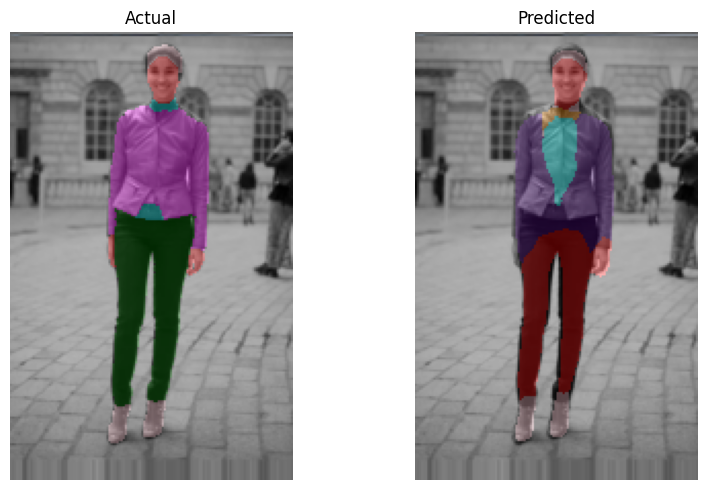

In [41]:
def show_sample():
    Net.eval()
    img = test_data[110:111].type(torch.FloatTensor).to(device)
    with torch.no_grad():
        pred = Net(img)
    pred_ann = get_labels(pred[0])
    return (pred[0].to(torch.device('cpu')),    # prediction
            pred_ann[0].to(torch.device('cpu')),# predicted annotations
            tf.ToPILImage()(test_data[110]),      # actual image
            test_target[110])                     # actual annotations


# quick fix to label2rgb to make sure labels stay consistent across images
def label2rgb_consistent(labels, img, max_label):
    labels = np.uint8(labels)
    img = np.uint8(img)

    # ensure labels occur in ascending order to make label2rgb map it to the same color
    pad_with = np.uint8(range(0, min(len(labels[0]), max_label)))
    if len(pad_with) < len(labels[2]):
        pad_with = np.concatenate([pad_with, np.zeros(len(labels[0])-len(pad_with))])
    pad_with = np.array([pad_with])

    labels[1] = pad_with # add phony labels
    result = color.label2rgb(labels, img)
    result[1] = img[1] # remove phony labels

    # scale to uni8 to get rid of warnings
    result = (result*255).astype(np.uint8)
    return result

(pred, pred_ann, img, actual_ann) = show_sample()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
                         sharex=True, sharey=True)


actual_result = label2rgb_consistent(actual_ann, img, 59)
pred_result = label2rgb_consistent(pred_ann, img, 59)

axes[0].imshow(actual_result)
axes[0].set_title('Actual')
axes[1].imshow(pred_result)
axes[1].set_title('Predicted')
for a in axes:
    a.axis('off')

fig.tight_layout()
plt.show()

In [43]:
def print_network_parameters():
    num_paras = 0
    for (name, paras) in list(Net.named_parameters()):
        n = 1
        for m in paras.size():
            n = n * m
        num_paras += n
        print(name, paras.size(), "this param", n, "total", num_paras)
    print("total", num_paras)

print_network_parameters()

stage1.rebnconvin.conv_s1.weight torch.Size([64, 3, 3, 3]) this param 1728 total 1728
stage1.rebnconvin.conv_s1.bias torch.Size([64]) this param 64 total 1792
stage1.rebnconvin.bn_s1.weight torch.Size([64]) this param 64 total 1856
stage1.rebnconvin.bn_s1.bias torch.Size([64]) this param 64 total 1920
stage1.rebnconv1.conv_s1.weight torch.Size([32, 64, 3, 3]) this param 18432 total 20352
stage1.rebnconv1.conv_s1.bias torch.Size([32]) this param 32 total 20384
stage1.rebnconv1.bn_s1.weight torch.Size([32]) this param 32 total 20416
stage1.rebnconv1.bn_s1.bias torch.Size([32]) this param 32 total 20448
stage1.rebnconv2.conv_s1.weight torch.Size([32, 32, 3, 3]) this param 9216 total 29664
stage1.rebnconv2.conv_s1.bias torch.Size([32]) this param 32 total 29696
stage1.rebnconv2.bn_s1.weight torch.Size([32]) this param 32 total 29728
stage1.rebnconv2.bn_s1.bias torch.Size([32]) this param 32 total 29760
stage1.rebnconv3.conv_s1.weight torch.Size([32, 32, 3, 3]) this param 9216 total 38976
s